In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pmdarima as pm
from math import sqrt


In [3]:
df=pd.read_csv('C:/Abdelouaheb/perso/Ph/time_series_analysis/data/data_article/hourly_5y_data.csv', index_col='time', parse_dates=True)

In [11]:
september_2023_data = df['2023-09']

C:\Users\waheb11\AppData\Local\Temp\ipykernel_38332\4098922020.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  september_2023_data = df['2023-09']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41607 entries, 2019-01-01 00:00:00 to 2023-09-30 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   measure  41607 non-null  float64
dtypes: float64(1)
memory usage: 650.1 KB


In [3]:
df.head()

,measure
time,
2019-01-01 00:00:00,13.996154
2019-01-01 01:00:00,13.470886
2019-01-01 02:00:00,10.388608
2019-01-01 03:00:00,8.771795
2019-01-01 04:00:00,7.373077


In [5]:
# Understanding the data for time based train-test split
print(f'Start Date: {df.index.min()}')
print(f'End Date: {df.index.max()}')
print(f'Total Days: {len(df)}')

Start Date: 2019-01-01 00:00:00
End Date: 2023-09-30 23:00:00
Total Days: 41607


In [6]:
# Check for missing values in the entire DataFrame
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
measure    0
dtype: int64


In [7]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [7]:
df.tail(2)

,measure
time,
2023-09-30 22:00:00,4.0
2023-09-30 23:00:00,4.4


In [13]:
# Time based train-test splitting
#test = df.loc['2023-09-30':]
#train = df.loc['2023-09-15':'2023-09-30']
# Assuming df is your DataFrame
# Get the total number of rows in the DataFrame
test = september_2023_data.loc['2023-09-29':'2023-09-30']
train = september_2023_data.loc['2023-09-01':'2023-09-29'] 

In [14]:
print(train.shape)
print("-"*50)
print(test.shape)

(687, 1)
--------------------------------------------------
(48, 1)


In [10]:
train

,measure
time,
2023-09-15 00:00:00,7.90
2023-09-15 01:00:00,10.65
2023-09-15 02:00:00,9.90
2023-09-15 03:00:00,10.15
2023-09-15 04:00:00,12.20
...,...
2023-09-30 19:00:00,2.25
2023-09-30 20:00:00,3.75
2023-09-30 21:00:00,4.75


In [15]:
train.sort_index(inplace=True)

In [17]:
train

,measure
time,
2023-08-30 15:00:00,32.200000
2023-08-30 16:00:00,27.333333
2023-08-30 17:00:00,21.016667
2023-08-30 18:00:00,11.900000
2023-08-30 19:00:00,10.883333
...,...
2023-09-29 19:00:00,2.750000
2023-09-29 20:00:00,1.600000
2023-09-29 21:00:00,1.400000


## ARIMA Model

In [ ]:
result = seasonal_decompose(train)
fig = plt.figure()  
fig = result.plot()
plt.show()

### Stationarity Test The Augmented Dickey-Fuller (ADF)

In [17]:
result=adfuller(train.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')


ADF Statistics:-4.458833520805671
p-value:0.0002332080189142683


ADF test. Here are the two hypotheses:

Null Hypothesis (H0): The null hypothesis assumes the presence of a unit root in the time series data, indicating that the data is non-stationary. 

Alternative Hypothesis (H1): The alternative hypothesis is the complement to the null hypothesis. It assumes the absence of a unit root, indicating that the data is stationary. 

In our case we can not reject H0 becasue p-value:0.19987116175608627 > 0.05

c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


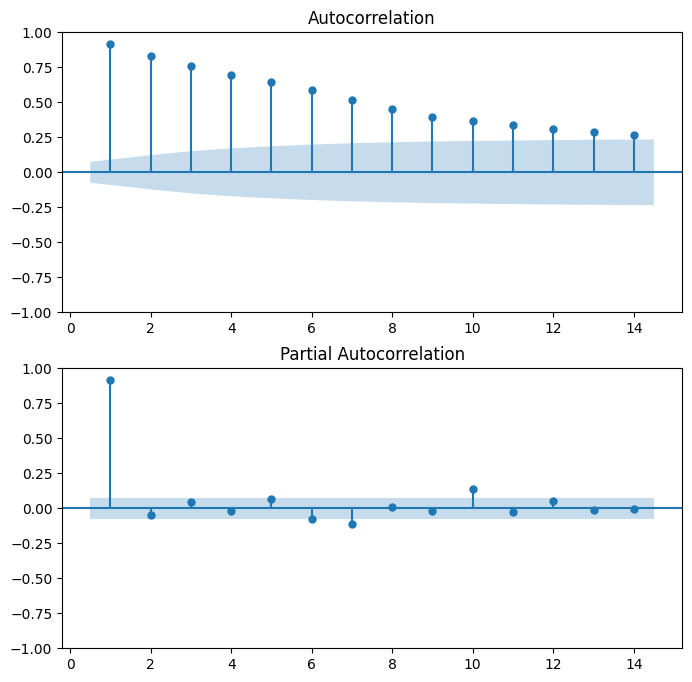

In [18]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(train,lags=14, zero=False, ax=ax1)
plot_pacf(train,lags=14, zero=False, ax=ax2)
plt.show()

### Choose model parameters ARIMA

In [19]:
results_arima=pm.auto_arima(train, d=0, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=False, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (6) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3399.869, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5498.374, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3398.079, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4739.852, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3399.903, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3399.577, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3378.456, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4638.887, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3378.923, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3378.743, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4027.188, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3378.544, Time=0.24 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.948 seconds


### Fit ARIMA model

In [20]:
model_arima=SARIMAX(train,order=(1,0,0))
results_arima=model_arima.fit()

c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                measure   No. Observations:                  687
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1697.040
Date:                Sun, 14 Apr 2024   AIC                           3398.079
Time:                        10:03:10   BIC                           3407.144
Sample:                             0   HQIC                          3401.586
                                - 687                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9754      0.004    253.647      0.000       0.968       0.983
sigma2         8.1511      0.114     71.796      0.000       7.929       8.374
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             54970.01
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               3.97   Skew:                            -1.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

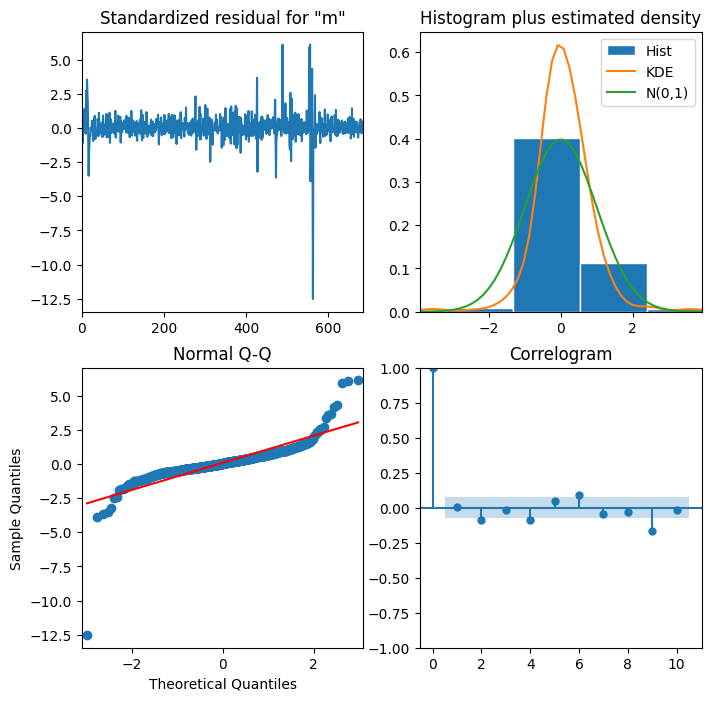

In [22]:
# Create the 4 diagostics plots
results_arima.plot_diagnostics(figsize=(8,8))
plt.show()

### Prediction using ARIMA

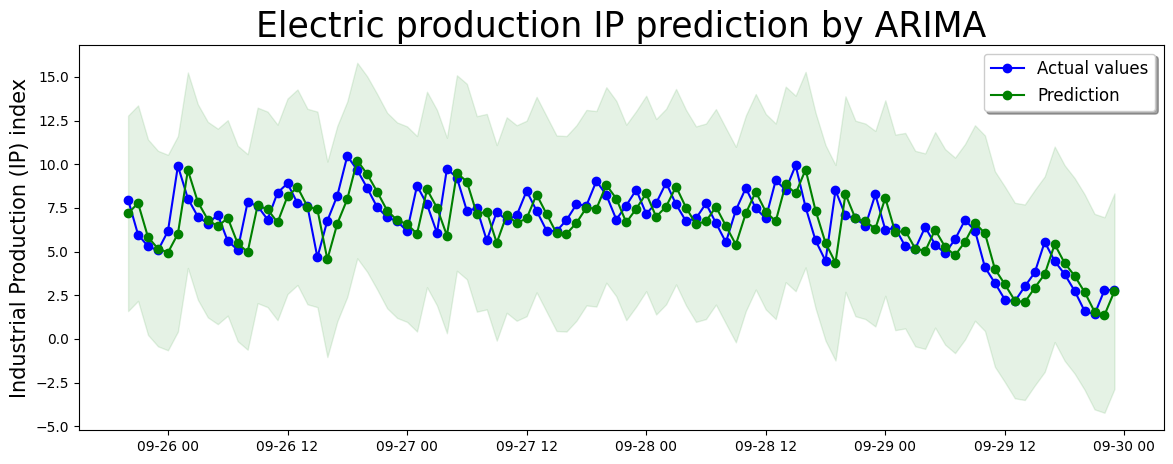

In [23]:
prediction_arima = results_arima.get_prediction(start=-100)
mean_prediction_arima=prediction_arima.predicted_mean
mean_prediction = mean_prediction_arima.rename("prediction")
confi_int_p_arima=prediction_arima.conf_int()
lower_limits_p_arima=confi_int_p_arima.iloc[:,0]
upper_limits_p_arima=confi_int_p_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by ARIMA", fontsize=25)

plt.plot(train[-100:].index,train[-100:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction_arima[-100:].index, mean_prediction_arima[-100:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction_arima[-100:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: operands could not be broadcast together with shapes (23,) (100,) 

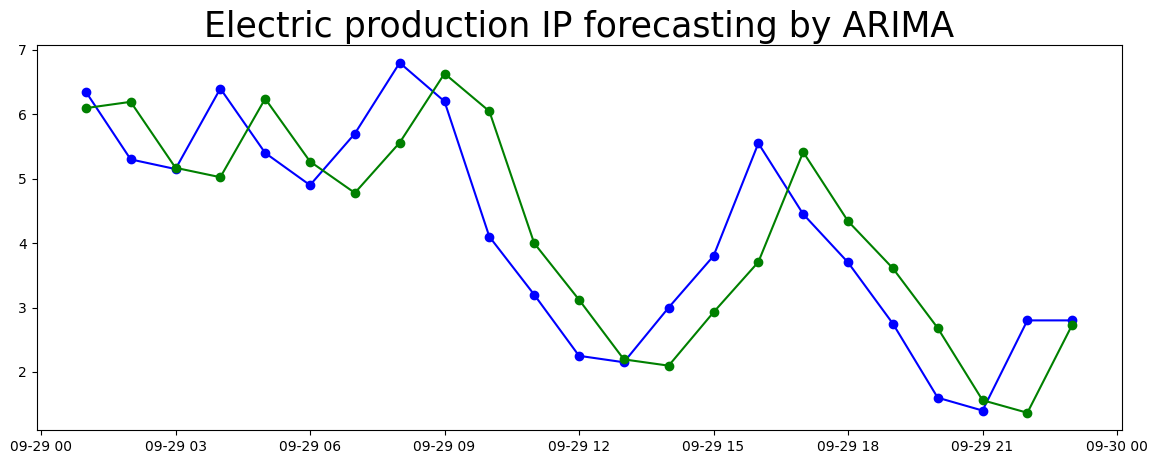

In [31]:
df_pred=train.iloc[-23:]
# Make ARIMA forecast of next 10 values
forecast_arima = results_arima.get_forecast(steps=23)
mean_forecast_arima=forecast_arima.predicted_mean
mean_forecast_arima = mean_forecast_arima.rename("prediction")
confi_int_f_arima=forecast_arima.conf_int()
lower_limits_f_arima=confi_int_f_arima.iloc[:,0]
upper_limits_f_arima=confi_int_f_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA", fontsize=25)

plt.plot(train[-23:].index,train[-23:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-23:].index, mean_prediction[-23:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-23:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.plot(mean_forecast_arima[-23:].index,mean_forecast_arima[-23:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast_arima[-23:].index, lower_limits_f_arima, upper_limits_f_arima, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-23:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [32]:
df_arima = pd.concat([mean_prediction_arima, mean_forecast_arima])

### SARIMA Model

In [33]:
results_sarimax=pm.auto_arima(train, d=0, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=24, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True,trend='ct')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=3355.670, Time=8.05 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=4702.704, Time=0.60 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=3487.784, Time=7.59 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=3968.925, Time=13.45 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=4702.704, Time=0.54 sec
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=10.64 sec
 ARIMA(1,0,1)(1,1,0)[24] intercept   : AIC=3486.701, Time=10.56 sec
 ARIMA(1,0,1)(2,1,1)[24] intercept   : AIC=3389.581, Time=131.03 sec
 ARIMA(1,0,1)(1,1,2)[24] intercept   : AIC=inf, Time=149.28 sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=3662.123, Time=1.20 sec
 ARIMA(1,0,1)(0,1,2)[24] intercept   : AIC=inf, Time=124.89 sec
 ARIMA(1,0,1)(2,1,0)[24] intercept   : AIC=3428.033, Time=53.70 sec
 ARIMA(1,0,1)(2,1,2)[24] intercept   : AIC=inf, Time=110.55 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=3969.869, Time=13.30 sec
 ARIMA(1,0,0)(1,1,1)[24] i

In [35]:
model_sarimax=SARIMAX(train,order=(1,0,1),  seasonal_order=(1,1,1, 24))
results_sarimax=model_sarimax.fit()
#ARIMA(1,0,1)(1,1,2)[24] 

c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [36]:
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            measure   No. Observations:                  687
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -1657.658
Date:                            Sun, 14 Apr 2024   AIC                           3325.317
Time:                                    10:31:25   BIC                           3347.801
Sample:                                         0   HQIC                          3334.030
                                            - 687                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9102      0.007    122.831      0.000       0.896       0.925
ma.L1          0.0654      0.027      2.441      0.015       0.013       0.118
ar.S.L24       0.0280      0.048      0.577      0.564      -0.067       0.123
ma.S.L24      -0.9203      0.032    -28.767      0.000      -0.983      -0.858
sigma2         8.1197      0.163     49.850      0.000       7.800       8.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31989.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.27   Skew:                            -1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

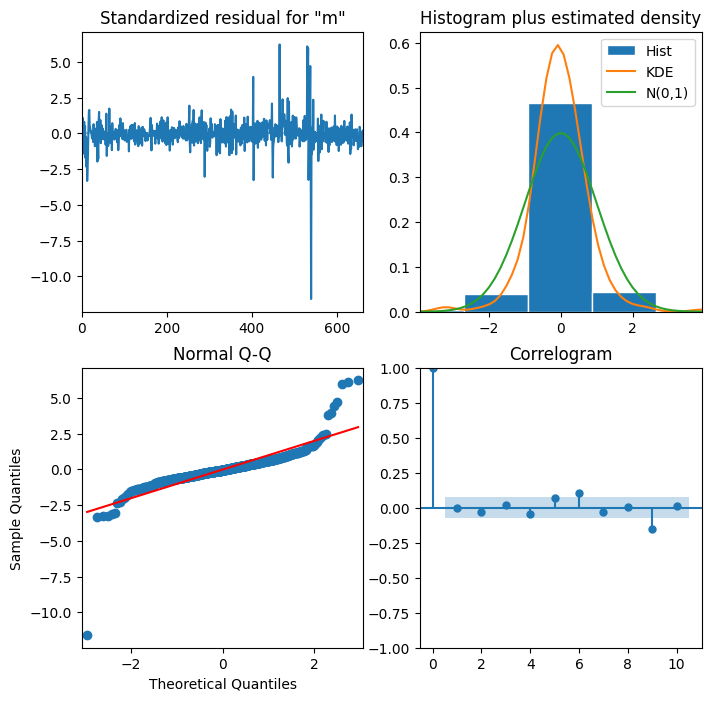

In [37]:
# Create the 4 diagostics plots
results_sarimax.plot_diagnostics(figsize=(8,8))
plt.show()

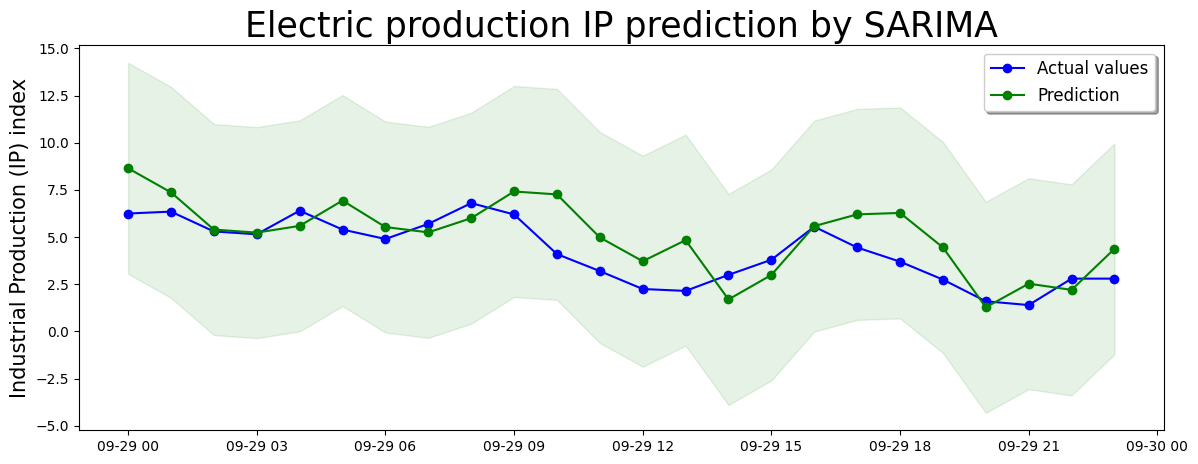

In [49]:
prediction = results_sarimax.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by SARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [ ]:
df_pred=train.iloc[-24:]
# Make ARIMA forecast of next 10 values
forecast_arima = results_arima.get_forecast(steps=24)
mean_forecast_arima=forecast_arima.predicted_mean
mean_forecast_arima = mean_forecast_arima.rename("prediction")
confi_int_f_arima=forecast_arima.conf_int()
lower_limits_f_arima=confi_int_f_arima.iloc[:,0]
upper_limits_f_arima=confi_int_f_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.plot(mean_forecast_arima[-24:].index,mean_forecast_arima[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast_arima[-24:].index, lower_limits_f_arima, upper_limits_f_arima, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-24:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [ ]:
rmse_arima = sqrt(mean_squared_error(train[-24:].values,mean_prediction_arima.values))
print(f"RMSE OF SARIMA MODEL : {rmse_arima:.2f}")

RMSE OF SARIMA MODEL : 2.07


In [ ]:
rmse_arima1 = sqrt(mean_squared_error(test[-24:].values,mean_forecast_arima.values))
print(f"RMSE OF SARIMA MODEL : {rmse_arima1:.2f}")

RMSE OF SARIMA MODEL : 2.85


In [ ]:
rmse_sarima = sqrt(mean_squared_error(train[-24:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

RMSE OF SARIMA MODEL : 2.51


In [ ]:
rmse_sarima1 = sqrt(mean_squared_error(test[-24:].values,mean_forecast.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima1:.2f}")

RMSE OF SARIMA MODEL : 3.12


In [ ]:
df_sarimax  = pd.concat([mean_prediction, mean_forecast])

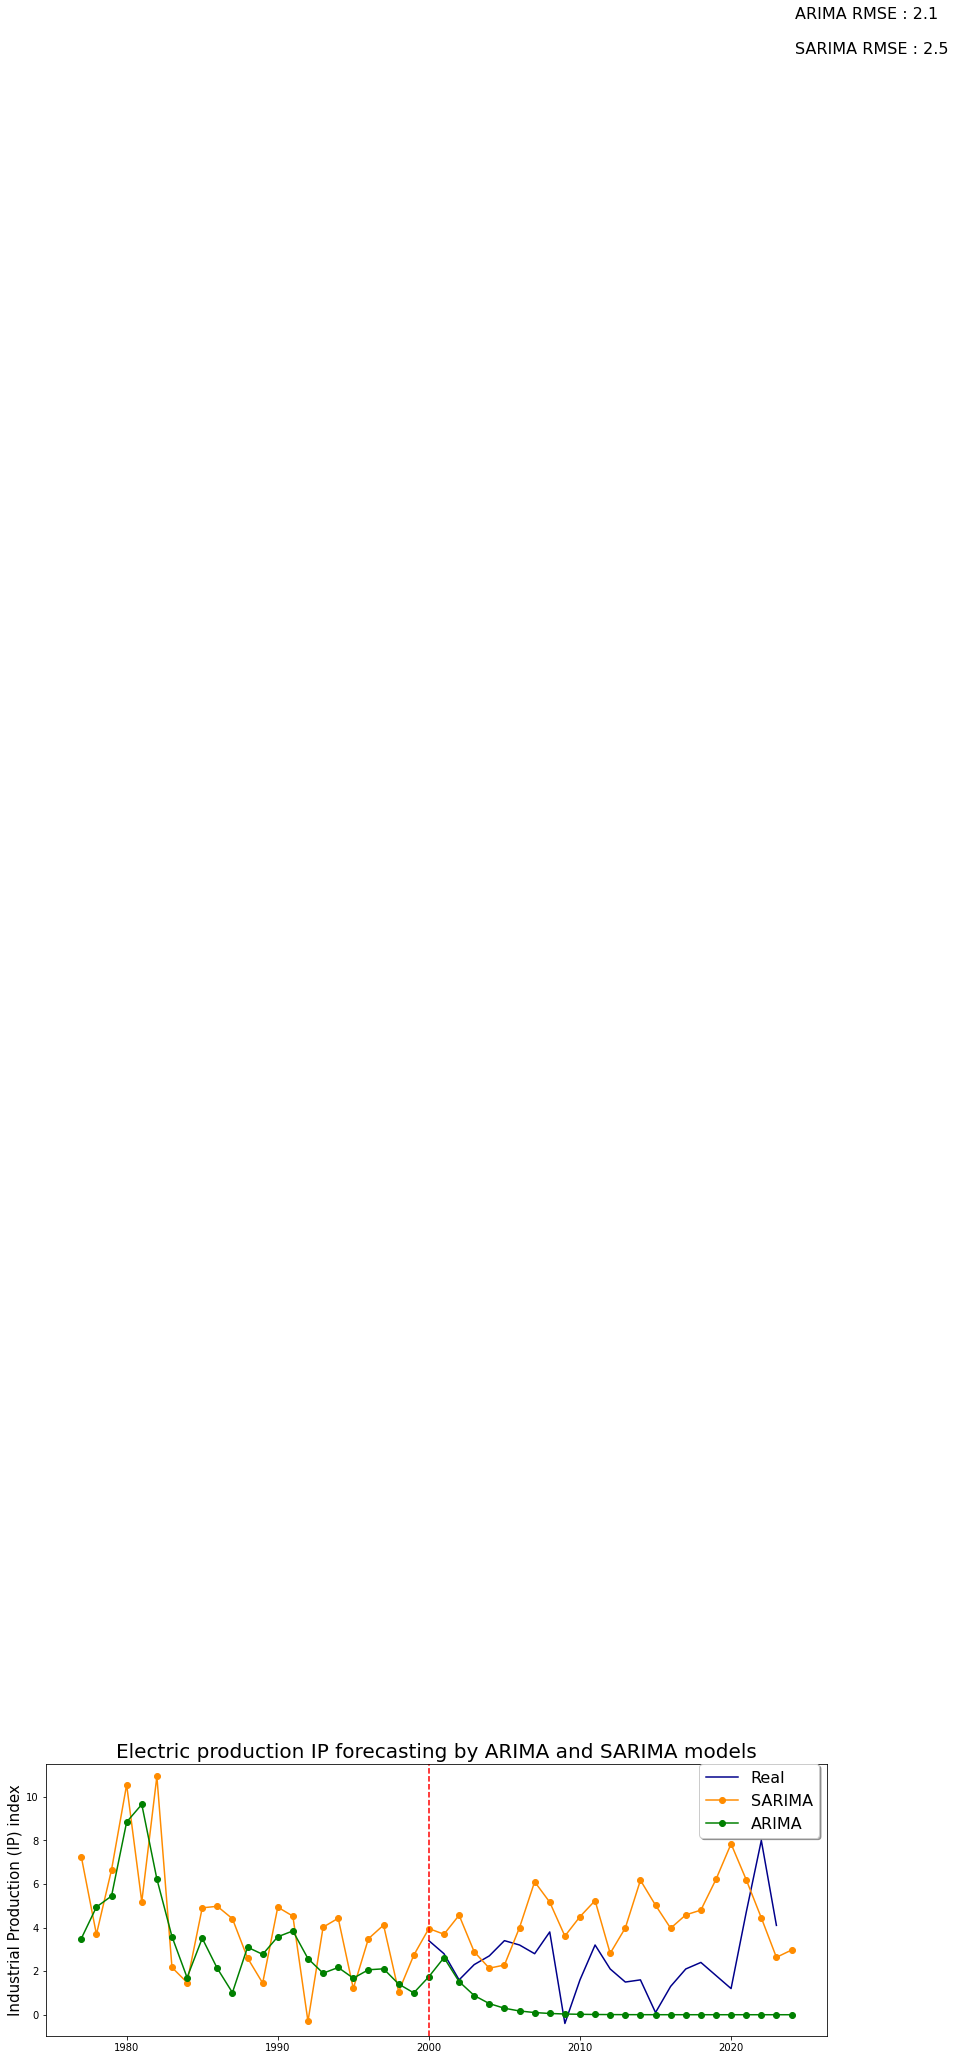

In [ ]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA and SARIMA models", fontsize=20)
plt.plot(test[-30:].index,test[-30:].values, color='darkblue', label='Real')
plt.plot(df_sarimax.index, df_sarimax.values, color='darkorange', label='SARIMA', marker='o')
plt.plot(df_arima.index, df_arima.values, color='green',label='ARIMA', marker='o')
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1, 1.03),fontsize=16,fancybox=True, shadow=True, frameon=True)
text = 'ARIMA RMSE : {:.1f}\n\nSARIMA RMSE : {:.1f} '.format(rmse_arima,rmse_sarima)
plt.text(mean_forecast.index[-1] + pd.DateOffset(days=80),90,text, fontsize=16)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [160]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(df['value'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
new= model_fit.forecast(24)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [162]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(df['value']),trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
print(model_fit.params)

new= model_fit.forecast(24)

{'smoothing_level': 0.5, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 68.39752666666662, 'initial_trend': -1.1764048484848448, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_19780\3650223120.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)


In [164]:
smooth = pd.DataFrame(new, columns=['Column_Name'])